In [10]:
#conda activate resnet50
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Suppress TensorFlow info and warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


##########################
train_directory="/local/data1/yanwa579/Data/resnet50_data/train"
valid_directory="/local/data1/yanwa579/Data/resnet50_data/valid"
epochs_num = 200
learning_rate=1e-5
##########################

# ResNet50 model without the top layer (the dense layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all layers
#base_model.trainable = False

# Freeze first n layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5, fill_mode='constant', fill_value=0.0),
    layers.RandomZoom(0.3, fill_mode='constant', fill_value=0.0),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0.0),  # Shift images
    layers.RandomContrast(0.3)
])

# Build the model
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(512, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve="ROC")]#,tf.keras.metrics.F1Score(name='f1_score')]
              )
# Data generators

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='binary')
val_generator = valid_datagen.flow_from_directory(
    valid_directory, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='binary')

# Compute class weights using 'balanced' method
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Stop the training when the model does not improve after 25 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=25)

history = model.fit(
    train_generator, 
    batch_size=32,
    epochs=epochs_num,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=2,
    shuffle=True)

Found 3211 images belonging to 2 classes.
Found 599 images belonging to 2 classes.
Epoch 1/200


/home/yanwa579/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 - 43s - 426ms/step - accuracy: 0.5662 - auc: 0.5653 - loss: 0.7024 - val_accuracy: 0.2838 - val_auc: 0.6019 - val_loss: 0.7637
Epoch 2/200
101/101 - 15s - 144ms/step - accuracy: 0.5749 - auc: 0.6006 - loss: 0.6900 - val_accuracy: 0.2287 - val_auc: 0.4745 - val_loss: 0.9736
Epoch 3/200
101/101 - 15s - 145ms/step - accuracy: 0.5836 - auc: 0.6165 - loss: 0.6792 - val_accuracy: 0.3606 - val_auc: 0.4589 - val_loss: 0.8165
Epoch 4/200
101/101 - 15s - 144ms/step - accuracy: 0.6073 - auc: 0.6281 - loss: 0.6696 - val_accuracy: 0.5292 - val_auc: 0.5885 - val_loss: 0.7166
Epoch 5/200
101/101 - 15s - 144ms/step - accuracy: 0.6088 - auc: 0.6458 - loss: 0.6664 - val_accuracy: 0.4107 - val_auc: 0.6215 - val_loss: 0.7974
Epoch 6/200
101/101 - 15s - 145ms/step - accuracy: 0.6288 - auc: 0.6511 - loss: 0.6597 - val_accuracy: 0.3907 - val_auc: 0.6697 - val_loss: 0.8371
Epoch 7/200
101/101 - 15s - 145ms/step - accuracy: 0.6145 - auc: 0.6689 - loss: 0.6468 - val_accuracy: 0.6210 - val_auc: 0.6727 - 

Training stopped at epoch 124


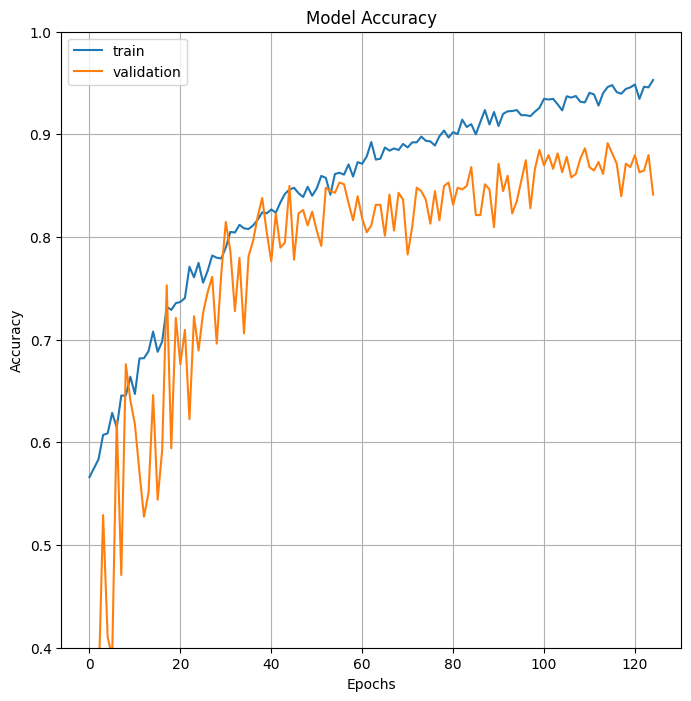

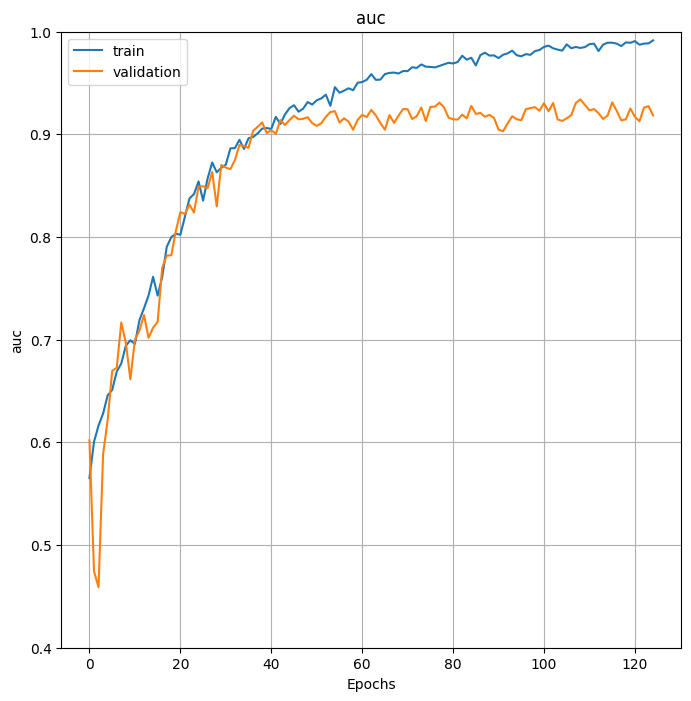

In [11]:
stopped_epoch = early_stop .stopped_epoch
print(f"Training stopped at epoch {stopped_epoch}")

# Plot training history
plt.figure(figsize=(8, 8))
epochs_range = range(stopped_epoch+1)
plt.plot(epochs_range, history.history['accuracy'], label = "Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label = "Validation Accuracy")
plt.axis(ymin = 0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot training history
plt.figure(figsize = (8, 8))
epochs_range = range(stopped_epoch+1)
plt.plot(epochs_range, history.history['auc'], label = "Training auc")
plt.plot(epochs_range, history.history['val_auc'], label = "Validation auc")
plt.axis(ymin = 0.4, ymax = 1)
plt.grid()
plt.title('auc')
plt.ylabel('auc')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Calculate F1 score
###########################################################################################
# Validation dataset is used to check the codes. Test dataset will be used in the future
###########################################################################################

labels_pred = model.predict(val_generator)
labels_pred = (labels_pred > 0.5).astype(int)
labels_pred = labels_pred.flatten().tolist()
valid_labels = val_generator.classes
f1 = f1_score(valid_labels, labels_pred)  # For binary classification
print("F1 Score:", f1)
# Calculate accuracy score
accuracy = accuracy_score(valid_labels, labels_pred)
print(f"Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
F1 Score: 0.7596048298572997
Accuracy: 0.6344


In [15]:
#Check if the values of each channel are the same

# Get a batch of images and labels
images, labels = train_generator.__next__()
print(f"Image shape: {images.shape}")
# Select the first image and label from the batch
image = images[0]
label = labels[0]
# Print image shape and label
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print('0:', np.max(image[:,:,0]), np.min(image[:,:,0]))
print('1:', np.max(image[:,:,1]), np.min(image[:,:,1]))
print('2:', np.max(image[:,:,2]), np.min(image[:,:,2]))
print(np.array_equal(image[:,:,0], image[:,:,1]))
print(np.array_equal(image[:,:,0], image[:,:,2]))
print('u0', np.unique(image[:,:,0]))

Image shape: (32, 224, 224, 3)
Image shape: (224, 224, 3)
Label: 1.0
0: 1.0 0.0
1: 1.0 0.0
2: 1.0 0.0
True
True
u0 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705883 0.0509804  0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411766 0.09803922 0.10196079 0.10588236 0.10980393 0.1137255
 0.11764707 0.12156864 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.18823531 0.19215688 0.19607845 0.20000002 0.20392159 0.20784315
 0.21176472 0.21568629 0.21960786 0.22352943 0.227451   0.23137257
 0.23529413 0.2392157  0.24313727 0.24705884 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.309